In [1]:
import os
import sys

### INITIALIZE DJANGO-GEO-SPAAS
src_dir = os.getcwd().split('nansat-lectures')[0]
os.environ['DJANGO_SETTINGS_MODULE'] = 'project.settings'
sys.path.insert(0, os.path.join(src_dir, 'django-geo-spaas', 'project'))
import django
django.setup()

In [2]:
import matplotlib.pyplot as plt
import numpy as np

from django.utils import timezone
from django.contrib.gis.geos import WKTReader

from nansat import Nansat, Domain, NSR
from geospaas.catalog.models import Dataset, DatasetURI
%matplotlib notebook

In [3]:
# Find GlobCurrent data after 1st January 2014
gc_datasets = Dataset.objects.filter(entry_title__contains='globcurrent',
                                 time_coverage_start__gt=timezone.datetime(2014,1,1,tzinfo=timezone.utc))

In [4]:
# Take the first GlobCurrent dataset, define region of interest, and reproject
#
# NOTE:
#       - only metadata is transferred from the source (in this case the Ifremer Hyrax server)
#       - operations are mapped in a vrt file (xml)
n = Nansat(gc_datasets[0].dataseturi_set.all()[0].uri)
d = Domain(NSR().wkt, '-te 10 -44 40 -30 -tr 0.125 0.125')
n.reproject(d, addmask=False)

/home/vagrant/miniconda/lib/python2.7/site-packages/nansat/mappers/opendap.py:89: UserWarning: Time consuming loading time from OpenDAP...
  warnings.warn('Time consuming loading time from OpenDAP...')

/home/vagrant/miniconda/lib/python2.7/site-packages/nansat/mappers/opendap.py:91: UserWarning: Loading time - OK!
  warnings.warn('Loading time - OK!')



In [5]:
# Search for drifters in the same region (defined at lon={0,360}) and time
drifterdomain = Domain(NSR().wkt, '-te 10 -44 40 -30 -tr 0.125 0.125')
geometry = WKTReader().read(drifterdomain.get_border_wkt(nPoints=1000))
drifters = Dataset.objects.filter(entry_title__contains='drifter', 
                                  time_coverage_start__range=[n.time_coverage_start-timezone.timedelta(days=15),
                                      n.time_coverage_end+timezone.timedelta(days=15)],
                                  geographic_location__geometry__intersects=geometry)
print len(drifters)

/home/vagrant/miniconda/lib/python2.7/site-packages/nansat/domain.py:680: UserWarning: > 180 deg correction to longitudes - disabled..
  warnings.warn("> 180 deg correction to longitudes - disabled..")

/home/vagrant/miniconda/lib/python2.7/site-packages/django/db/models/fields/__init__.py:1453: RuntimeWarning: DateTimeField Dataset.time_coverage_start received a naive datetime (2013-12-18 00:00:00) while time zone support is active.
  RuntimeWarning)

/home/vagrant/miniconda/lib/python2.7/site-packages/django/db/models/fields/__init__.py:1453: RuntimeWarning: DateTimeField Dataset.time_coverage_start received a naive datetime (2014-01-18 00:00:00) while time zone support is active.
  RuntimeWarning)



10


In [6]:
# Get zonal and meridional geostrophic current
#
# NOTE:
#      - the xml-mapped operations are now performed
#      - actual data is streamed and assigned to variables as numpy arrays
u = n['eastward_geostrophic_current_velocity']
v = n['northward_geostrophic_current_velocity']

<IPython.core.display.Javascript object>


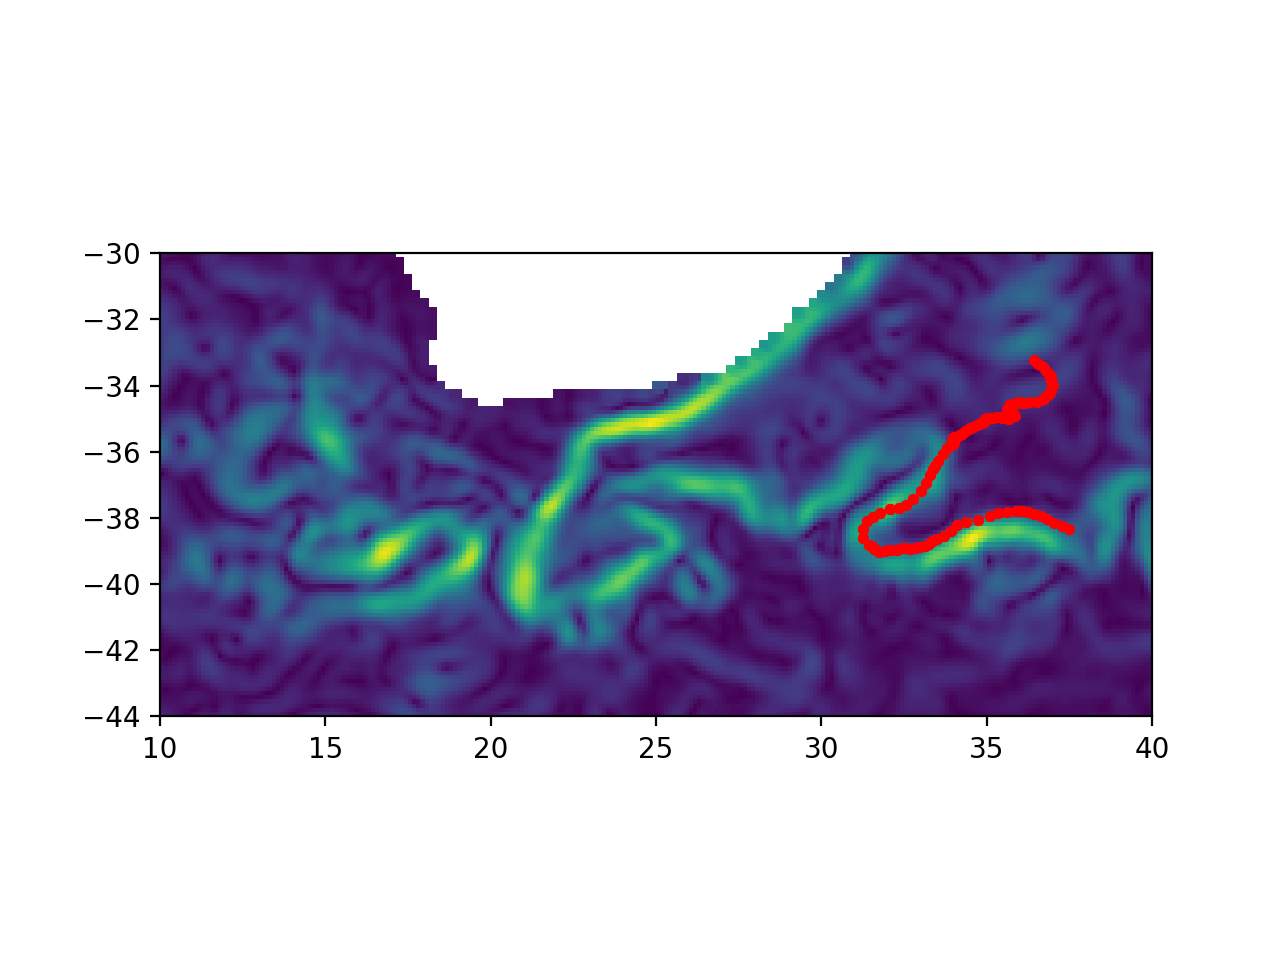

In [7]:
# Plot surface geostrophic current and collocated drifters
plt.figure()
plt.imshow(np.hypot(u, v), extent=(10,40,-44,-30))
for d in drifters:
    try:
        coords = np.array(d.geographic_location.geometry.coords).T
        plt.plot(coords[0], coords[1],'r.')
    except:
        continue

In [8]:
# Add virtual drifter functions
from scipy import ndimage
def rungekutta4(x, y, u0, v0, u1, v1, x0, y0, h):
    ''' Integrate velocity field using Runge-Kutta 4th order '''
    # convert grid with initial X (in meters) to columns
    xMin, xMax = float(x.min()), float(x.max())
    x1 = (x0 - xMin) / (xMax - xMin) * (x.shape[1] - 1)

    # convert grid with initial Y (in meters) to rows (reverse)
    yMin, yMax = float(y.min()), float(y.max())
    y1 = (yMax - y0) / (yMax - yMin) * (y.shape[0] - 1)

    # rescale h to be in rows/cols
    dx = float(np.diff(x)[0,0])
    h /= dx

    k1 = h * ndimage.map_coordinates(u0, [y1, x1], order=1, cval=np.nan)
    l1 =-h * ndimage.map_coordinates(v0, [y1, x1], order=1, cval=np.nan)

    k2 = h * ndimage.map_coordinates((u0 + u1) / 2, [y1 + l1 / 2, x1 + k1 / 2], order=1, cval=np.nan)
    l2 =-h * ndimage.map_coordinates((v0 + v1) / 2, [y1 + l1 / 2, x1 + k1 / 2], order=1, cval=np.nan)

    k3 = h * ndimage.map_coordinates((u0 + u1) / 2, [y1 + l2 / 2, x1 + k2 / 2], order=1, cval=np.nan)
    l3 =-h * ndimage.map_coordinates((v0 + v1) / 2, [y1 + l2 / 2, x1 + k2 / 2], order=1, cval=np.nan)

    k4 = h * ndimage.map_coordinates(u1, [y1 + l3, x1 + k3], order=1, cval=np.nan)
    l4 =-h * ndimage.map_coordinates(v1, [y1 + l3, x1 + k3], order=1, cval=np.nan)

    x5 = x1 + (k1 + 2 * k2 + 2 * k3 + k4) / 6
    y5 = y1 + (l1 + 2 * l2 + 2 * l3 + l4) / 6

    # convert rows/cols back to meters
    xOut = x5 / (x.shape[1] - 1) * (xMax - xMin) + xMin
    yOut = yMax - y5 / (x.shape[0] - 1) * (yMax - yMin)

    return xOut, yOut

NMAX = 100.
def run_rk4(xgrd, ygrd, u, v, h, xx, yy, n=0):
    if (xx[-1] > xgrd.max() or
        xx[-1] < xgrd.min() or
        yy[-1] > ygrd.max() or
        yy[-1] < ygrd.min() or
        n > NMAX):
        return xx, yy
    #print xx, yy, n
    x1, y1 = rungekutta4(xgrd, ygrd, u, v, u, v, np.array([xx[-1]]), np.array([yy[-1]]), h)
    xx.append(x1[0])
    yy.append(y1[0])
    return run_rk4(xgrd, ygrd, u, v, h, xx, yy, n+1)

In [9]:
lon, lat = n.get_geolocation_grids()

<IPython.core.display.Javascript object>


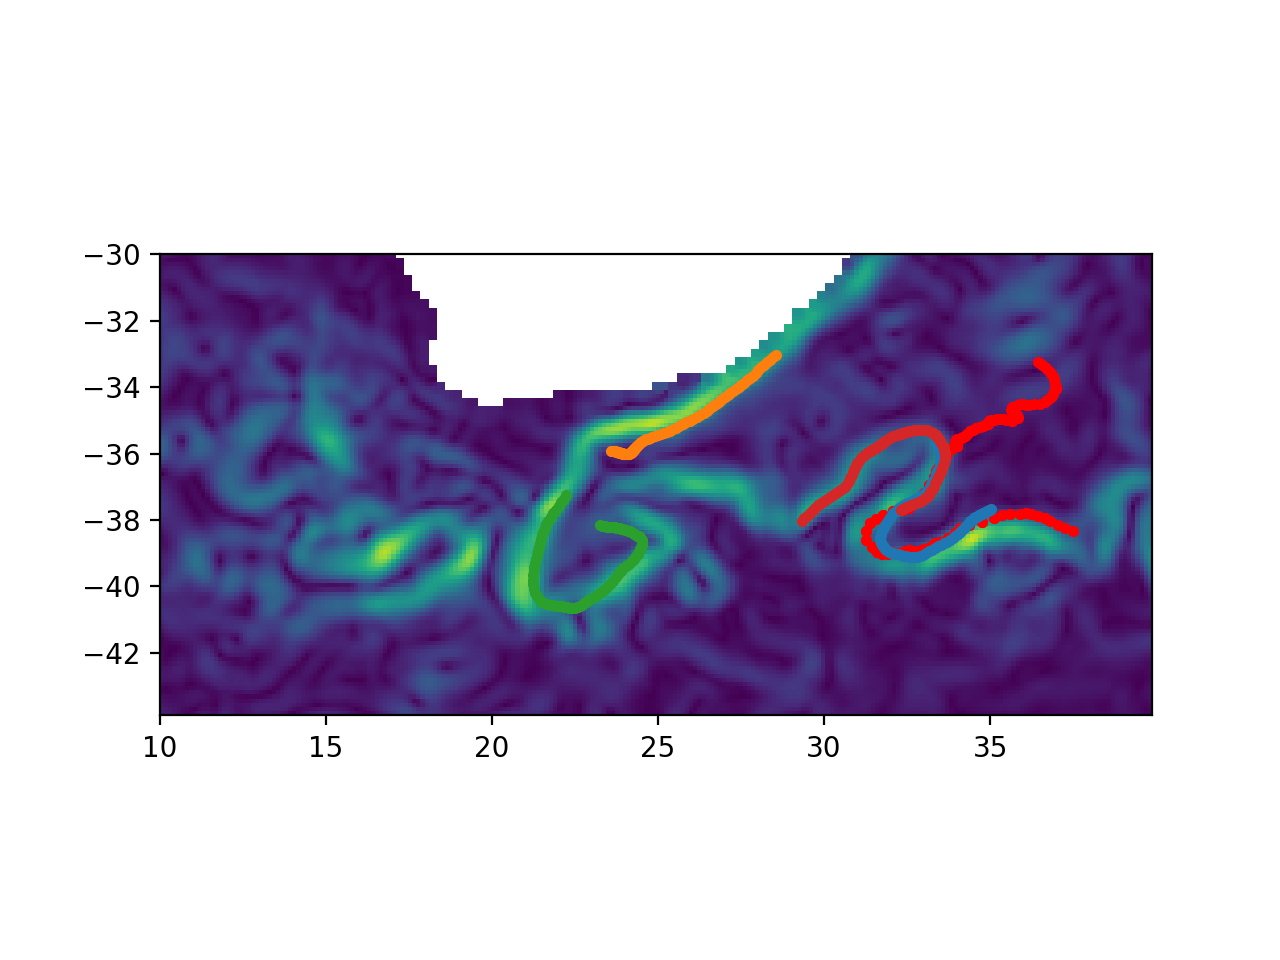

None None


In [10]:
# Plot surface geostrophic current, collocated drifters, and allow interactive animation
# of virtual drifters
h = 0.1
xgrd, ygrd = lon.copy(), lat.copy()
xx, yy = None, None

# interactive animation (local Jupyter-notebook)
fig = plt.figure()
ax1 = fig.add_subplot(111)

def click(event):
    global x0, y0, xx, yy
    if event.button==1 and event.inaxes:#select initial conditions pressing left mouse button 
        x0,y0 = event.xdata, event.ydata
        print x0, y0
        xx,yy = run_rk4(xgrd, ygrd, u, v, h, [x0], [y0])
        ax1.plot(xx, yy, '.-')
        fig.canvas.draw()

img1 = ax1.imshow(np.hypot(u,v), extent=[xgrd.min(), xgrd.max(), ygrd.min(), ygrd.max()], vmax=2);
for d in drifters:
    try:
        coords = np.array(d.geographic_location.geometry.coords).T
        ax1.plot(coords[0], coords[1],'r.')
    except:
        continue
#plt.colorbar(img1)
plt.connect('button_press_event', click)
plt.show()
print xx, yy